In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "mnist_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using MNIST dataset"

from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

input_var = T.matrix('inputs')
target_var = T.ivector('targets')

Using MNIST dataset


Using Theano backend.


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 784),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((784,), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.DenseLayer(l_noise, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

Starting training...
Epoch 1 of 50 took 2.779s
  training loss:		0.479064
  validation loss:		0.191972
  validation accuracy:		94.37 %
Epoch 2 of 50 took 2.824s
  training loss:		0.219869
  validation loss:		0.133617
  validation accuracy:		95.92 %
Epoch 3 of 50 took 2.750s
  training loss:		0.168053
  validation loss:		0.107457
  validation accuracy:		96.73 %
Epoch 4 of 50 took 3.229s
  training loss:		0.136328
  validation loss:		0.096986
  validation accuracy:		96.93 %
Epoch 5 of 50 took 3.237s
  training loss:		0.116115
  validation loss:		0.084837
  validation accuracy:		97.30 %
Epoch 6 of 50 took 2.905s
  training loss:		0.103301
  validation loss:		0.077774
  validation accuracy:		97.45 %
Epoch 7 of 50 took 2.777s
  training loss:		0.091582
  validation loss:		0.074523
  validation accuracy:		97.53 %
Epoch 8 of 50 took 2.851s
  training loss:		0.081317
  validation loss:		0.068561
  validation accuracy:		97.86 %
Epoch 9 of 50 took 3.417s
  training loss:		0.075238
  validation l

In [8]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(3, 2, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")

In [9]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [10]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    if plot:
        plt.figure()
        show_mnist(test_x[orig_img], 1, "Original")
        show_mnist(test_x[orig_img] + x, 2, "Adversarial")
        plt.show()

    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [38]:
def orig_adv_dist(orig_img = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
            print(np.argmax(pred), test_y[orig_img], pred)

    adv_label = test_y[orig_img]
    while adv_label ==  test_y[orig_img]:
        adv_label = np.random.randint(0, 10)
        
    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 50, base = 2, dtype = np.float32)
    plot_intersection = plot
    
    for i, c in enumerate(C):
        plot_current = plot and (i == 0 or i == 49)
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = plot_current)
        if plot_current:
            print ad, o_prob, a_prob
        if plot_intersection and o_prob >= a_prob:
            adv_test(orig_img, adv_label, C=C[i-1], plot = True)
            plot_intersection = False
            print ad, o_prob, a_prob
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, adv_prob, c='red', label = "Adversarial")
        plt.scatter(adv_norm, orig_prob, c='blue', label = "Original")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_prob[i] for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_prob[i] for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [orig_prob[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [orig_prob[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Probability")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, scipy.special.logit(adv_prob), c='red', label = "Adversarial")
        plt.scatter(adv_norm, scipy.special.logit(orig_prob), c='blue', label = "Original")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if x], c='orange', label = "Adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(adv_prob[i]) for i, x in enumerate(adv) if not x], c='cyan', label = "Non-adversarial Adv")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if x], c='red', label = "Adversarial Orig")
        #plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [scipy.special.logit(orig_prob[i]) for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial Orig")
        plt.ylabel("Logit")
        plt.xlabel("Adversarial distortion")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(1, 1, array([[  1.72682561e-12,   9.99712765e-01,   2.55481318e-05,
          4.39795009e-08,   1.87365989e-09,   4.99114972e-09,
          2.60955538e-04,   1.13621548e-08,   7.03827368e-07,
          4.97997902e-15]], dtype=float32))
Img 2815 Adv label 3


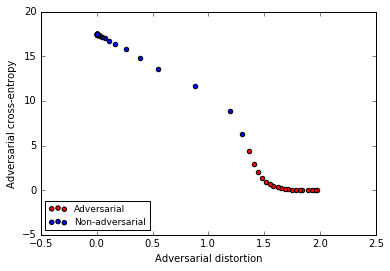

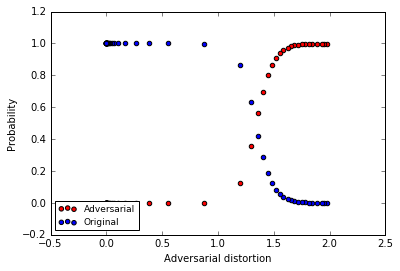

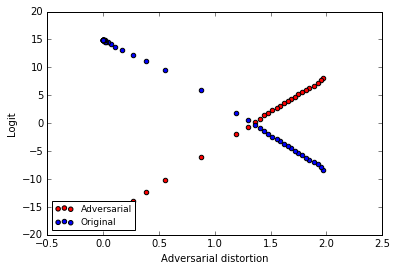

(5, 5, array([[  6.20995058e-17,   8.68453902e-15,   5.93765836e-18,
          3.88822796e-09,   1.95295081e-19,   1.00000000e+00,
          6.04214732e-15,   1.72862902e-18,   2.52577839e-14,
          6.26580454e-10]], dtype=float32))
Img 7018 Adv label 4


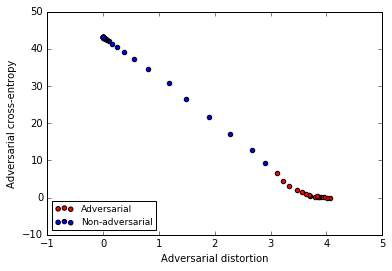

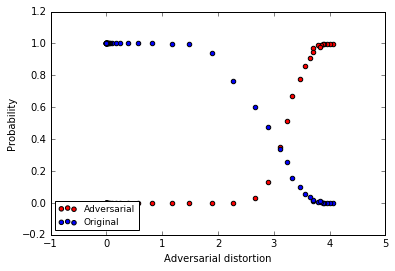

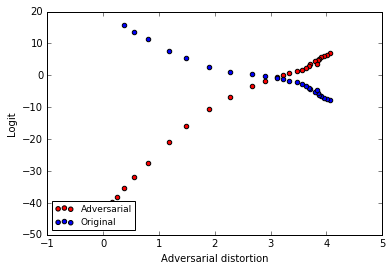

(0, 0, array([[  1.00000000e+00,   5.99646065e-14,   1.47376635e-08,
          3.73187682e-15,   5.95214999e-14,   1.00826584e-14,
          4.83695826e-11,   1.33817237e-11,   5.65241647e-12,
          1.44663621e-11]], dtype=float32))
Img 8067 Adv label 8


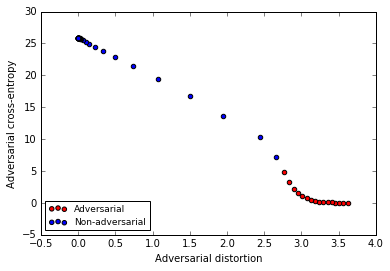

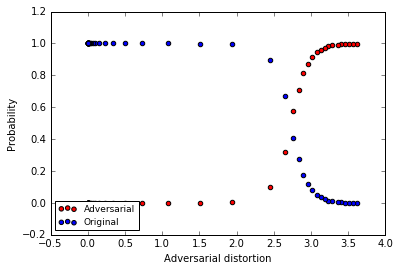

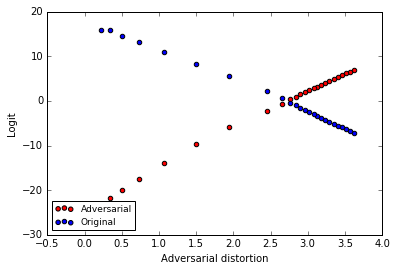

(1, 1, array([[  8.27733160e-11,   9.99981046e-01,   2.65896656e-08,
          2.53856158e-10,   3.31059510e-07,   9.97152361e-12,
          1.34332101e-09,   1.85999961e-05,   1.68297165e-09,
          2.48625509e-10]], dtype=float32))
Img 3148 Adv label 6


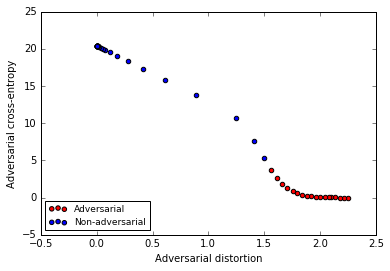

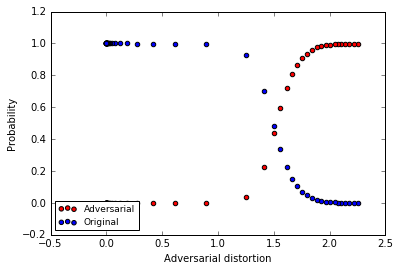

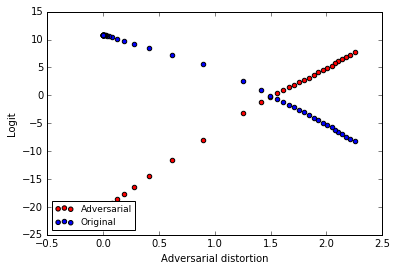

(6, 6, array([[  1.33829087e-10,   4.26205105e-13,   3.47692605e-13,
          2.34662351e-19,   2.04097086e-10,   2.85206993e-12,
          1.00000000e+00,   4.29187275e-15,   5.24733631e-13,
          1.38448007e-17]], dtype=float32))
Img 5153 Adv label 3


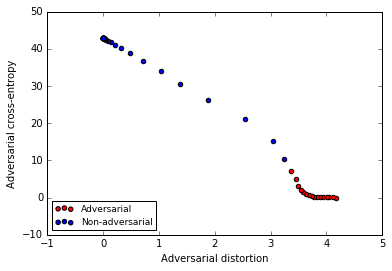

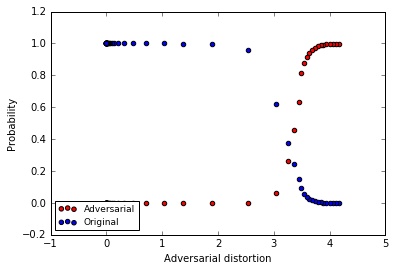

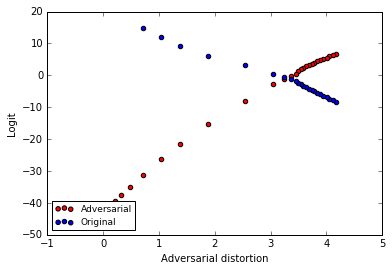

(4, 4, array([[  5.46798291e-14,   8.58849991e-10,   5.65985010e-14,
          4.80964112e-15,   1.00000000e+00,   4.38956441e-11,
          5.69748567e-13,   3.74210307e-09,   1.72942173e-13,
          1.78417494e-08]], dtype=float32))
Img 169 Adv label 1


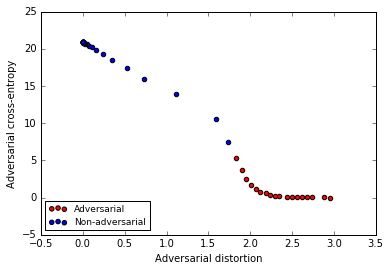

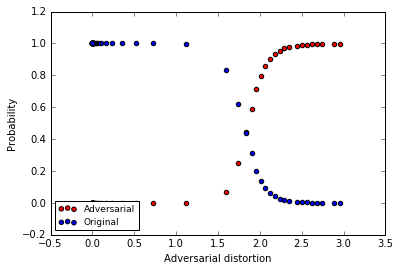

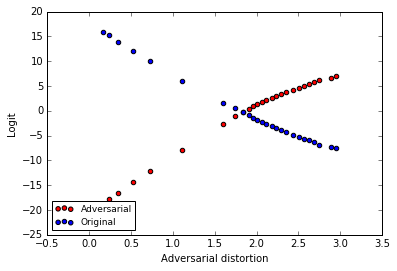

(5, 5, array([[  7.27762304e-17,   2.59848993e-19,   3.81776770e-22,
          6.65103416e-14,   9.79073874e-22,   1.00000000e+00,
          1.70437455e-16,   6.01398407e-19,   1.99575173e-17,
          2.24210949e-12]], dtype=float32))
Img 5400 Adv label 7


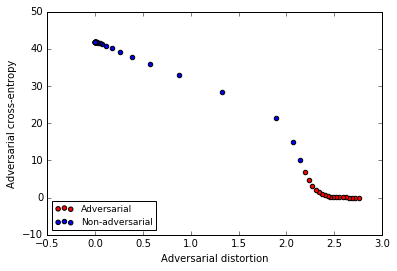

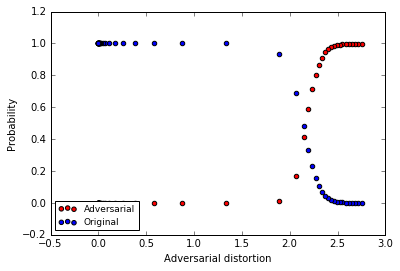

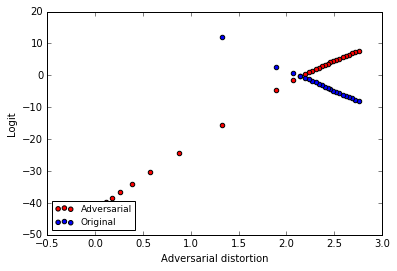

(7, 7, array([[  2.11099027e-09,   6.67931954e-06,   1.07184803e-07,
          4.04646876e-08,   5.35342650e-08,   2.13627546e-10,
          9.26584677e-12,   9.99992371e-01,   1.05800291e-09,
          7.19852324e-07]], dtype=float32))
Img 8956 Adv label 4


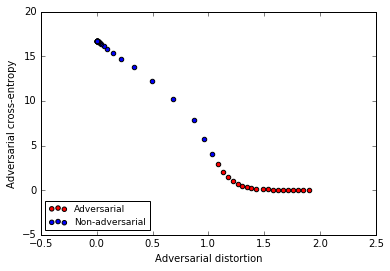

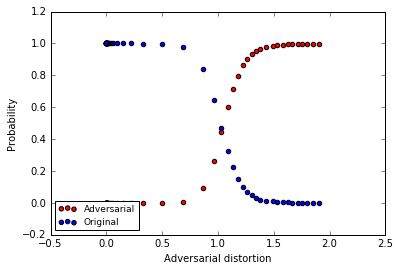

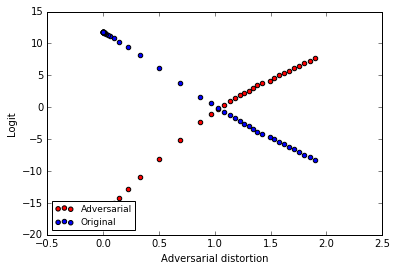

(8, 8, array([[  3.82110033e-09,   2.20863883e-09,   2.12516838e-07,
          2.33718325e-07,   2.46334841e-10,   7.30996685e-09,
          2.85336128e-08,   3.44801993e-10,   9.99999285e-01,
          2.10114237e-07]], dtype=float32))
Img 2297 Adv label 6


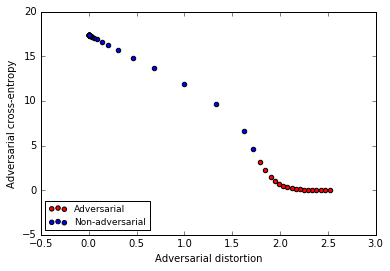

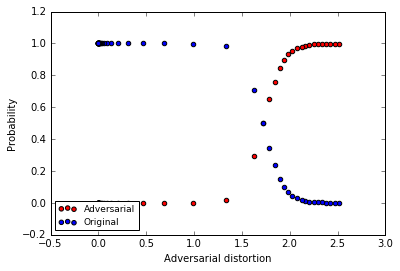

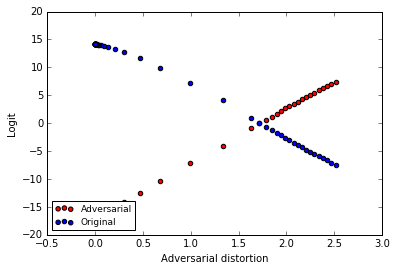

(9, 9, array([[  5.09263378e-12,   1.00082954e-11,   6.31800059e-13,
          2.94870156e-10,   2.41747415e-07,   1.48008298e-12,
          1.18179104e-14,   3.77111604e-08,   4.78292406e-10,
          9.99999762e-01]], dtype=float32))
Img 7828 Adv label 6


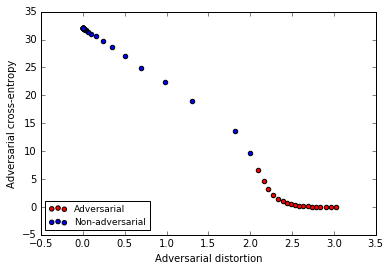

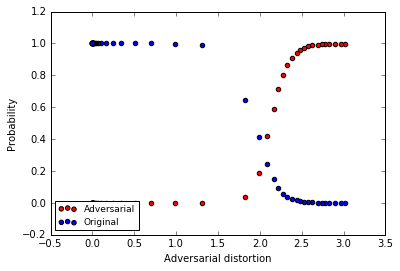

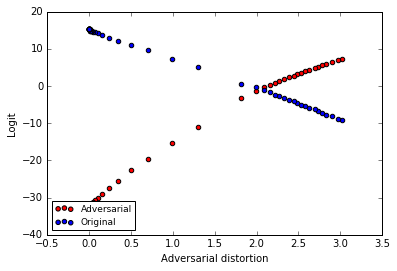

(1, 1, array([[  1.87442596e-12,   9.99999762e-01,   1.18685770e-10,
          1.63440692e-10,   6.25639913e-08,   5.84752941e-11,
          1.63553071e-09,   7.55604503e-08,   2.95600415e-08,
          2.74894829e-10]], dtype=float32))
Img 5524 Adv label 8


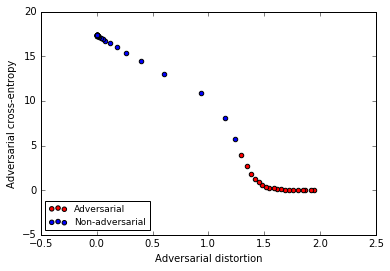

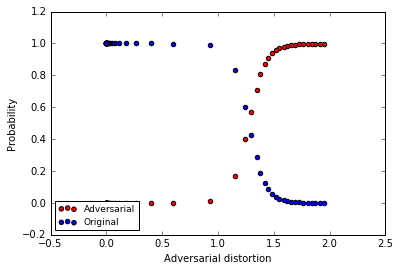

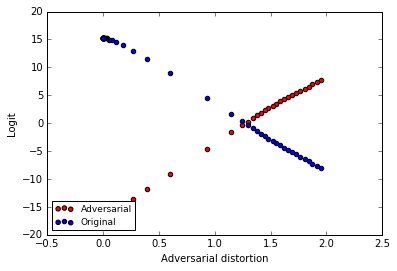

(4, 4, array([[  5.88617154e-13,   3.39834294e-08,   2.48243293e-13,
          4.60661511e-13,   9.99994397e-01,   4.61549660e-10,
          2.90283464e-10,   1.42378866e-07,   1.24901062e-10,
          5.43068199e-06]], dtype=float32))
Img 708 Adv label 7


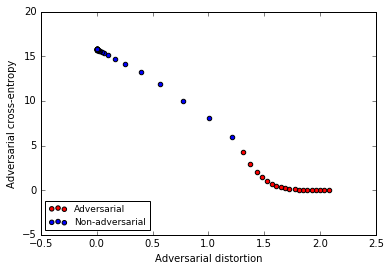

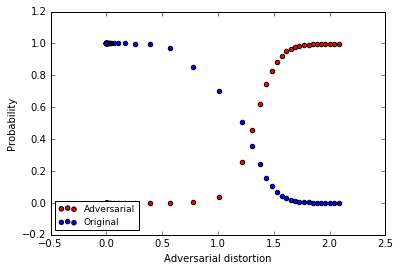

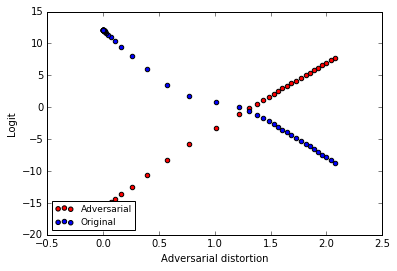

(6, 6, array([[  9.49255452e-10,   2.65863753e-09,   3.60002722e-10,
          1.02742345e-13,   1.33444980e-08,   1.14256524e-08,
          1.00000000e+00,   3.27766893e-12,   1.36511184e-11,
          1.34656143e-12]], dtype=float32))
Img 5793 Adv label 1


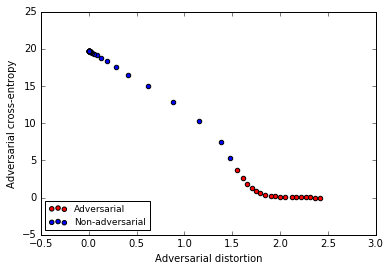

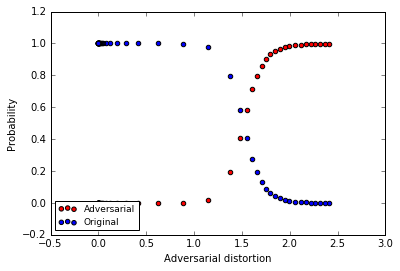

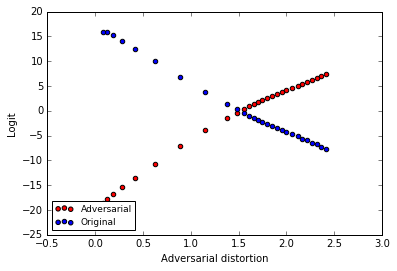

(9, 9, array([[  4.35824224e-11,   5.42634583e-11,   8.29391347e-11,
          1.41352130e-09,   1.76231006e-05,   4.82640761e-10,
          1.04231355e-13,   1.68405245e-06,   1.80822191e-10,
          9.99980688e-01]], dtype=float32))
Img 4182 Adv label 8


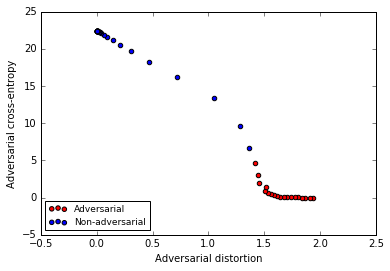

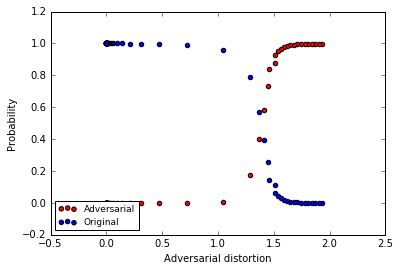

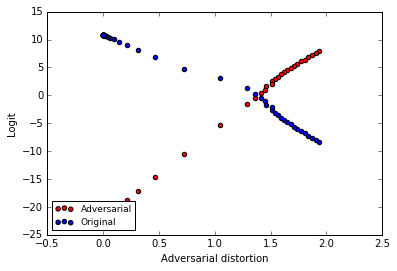

(3, 3, array([[  7.81187994e-13,   8.11649414e-09,   1.97699964e-11,
          9.99999523e-01,   1.64495709e-11,   3.05671932e-07,
          1.93165172e-13,   1.52573336e-11,   1.02457431e-09,
          1.49387688e-07]], dtype=float32))
Img 683 Adv label 7


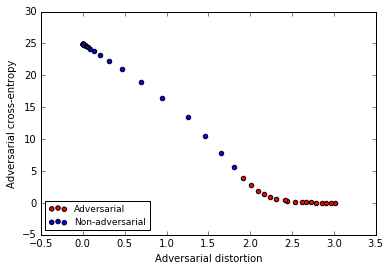

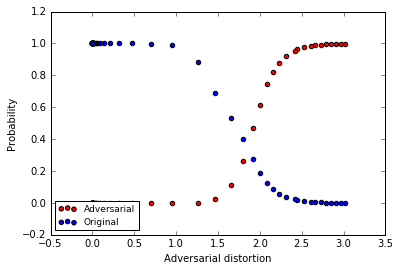

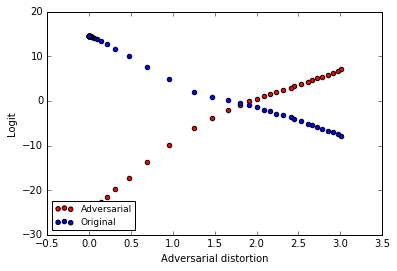

(6, 6, array([[  1.84895467e-11,   1.03478742e-13,   4.53182061e-13,
          6.38174634e-16,   1.17539962e-12,   1.26628610e-08,
          1.00000000e+00,   4.16205487e-17,   1.15496588e-11,
          6.40407595e-14]], dtype=float32))
Img 8133 Adv label 8


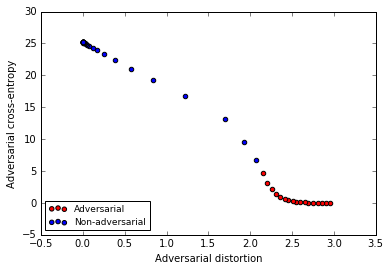

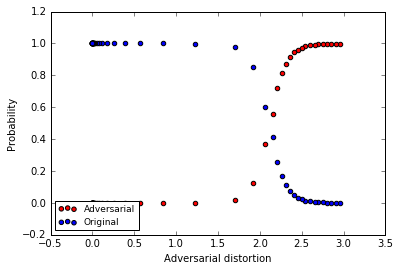

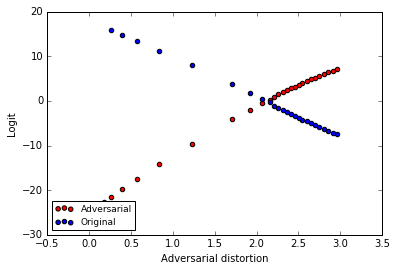

(2, 2, array([[  3.28992000e-10,   6.43349540e-10,   1.00000000e+00,
          4.61082017e-09,   3.90627777e-14,   1.01135924e-15,
          1.83957460e-09,   6.74013623e-10,   5.10475553e-14,
          4.96129862e-17]], dtype=float32))
Img 7627 Adv label 7


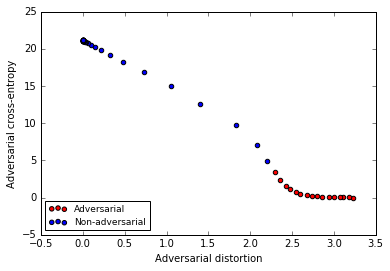

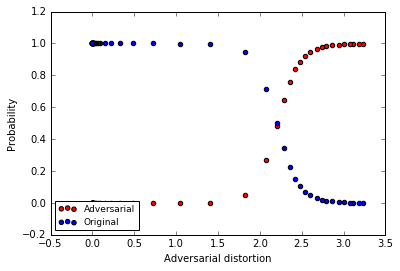

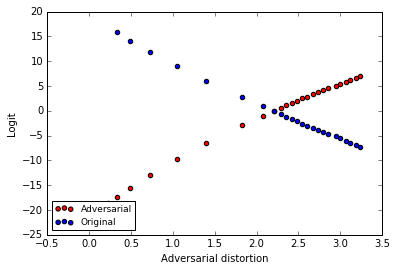

(2, 2, array([[  2.00592529e-11,   7.78188847e-10,   9.99994993e-01,
          1.87377491e-08,   1.23356392e-08,   7.54925011e-10,
          1.23440277e-11,   4.99228099e-06,   1.49605656e-13,
          8.26171610e-14]], dtype=float32))
Img 7212 Adv label 4


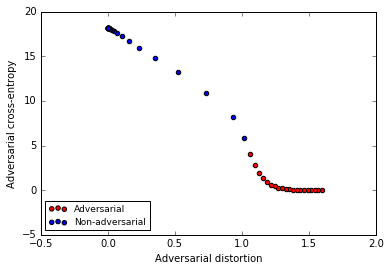

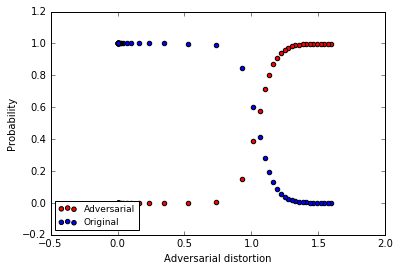

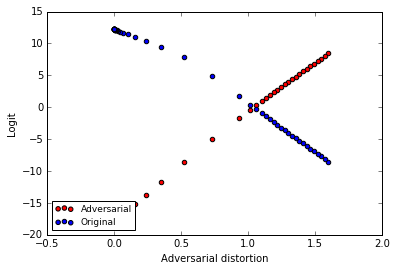

(0, 0, array([[  1.00000000e+00,   2.42364875e-14,   5.41196393e-11,
          1.03595105e-15,   1.01186880e-16,   6.77598255e-12,
          1.59019886e-09,   8.01701912e-13,   2.97647311e-17,
          7.17013390e-16]], dtype=float32))
Img 2217 Adv label 9


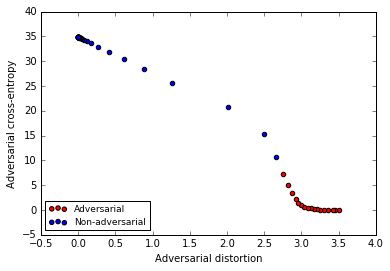

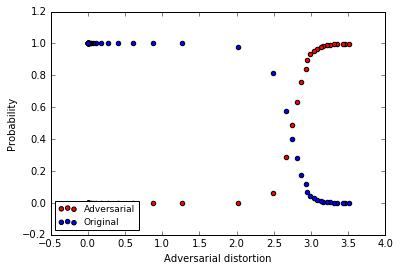

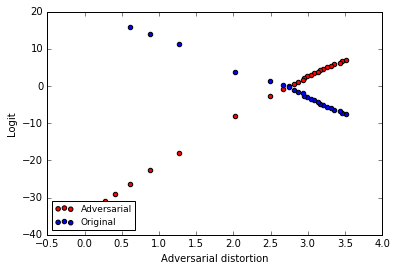

(6, 6, array([[  4.82033222e-08,   1.38500267e-09,   2.79378656e-11,
          3.43841622e-11,   2.68048694e-10,   3.00439439e-07,
          9.99999642e-01,   2.59406385e-12,   1.87100611e-08,
          7.31836466e-12]], dtype=float32))
Img 3424 Adv label 5


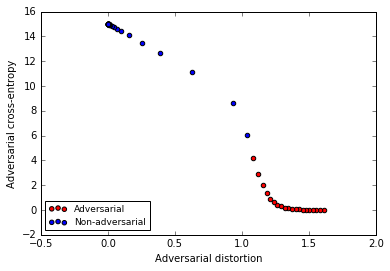

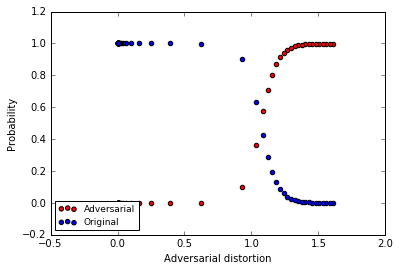

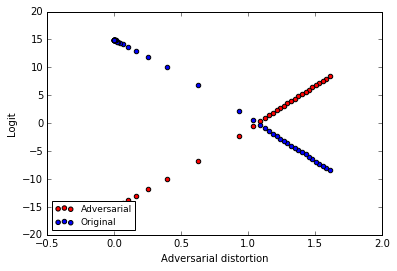

(8, 8, array([[  4.44675319e-09,   5.49518708e-10,   2.23718459e-07,
          1.11212920e-07,   2.10812520e-10,   3.83819525e-07,
          2.63114934e-08,   5.48312562e-10,   9.99998569e-01,
          6.71607324e-07]], dtype=float32))
Img 563 Adv label 6


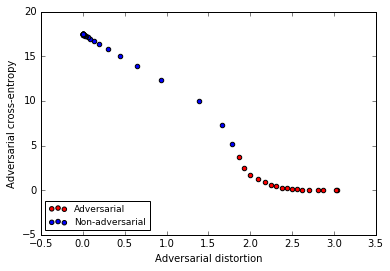

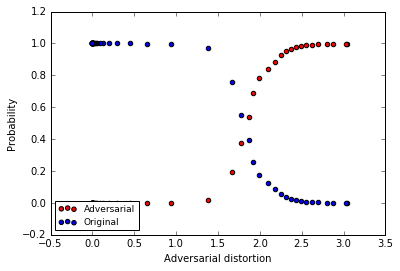

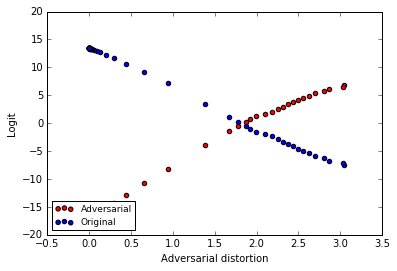

(2, 2, array([[  1.58843432e-05,   2.19342951e-06,   9.98200774e-01,
          1.77542563e-03,   1.65729982e-11,   5.71942883e-06,
          5.73545256e-09,   4.31268283e-08,   3.65237227e-08,
          7.59338903e-09]], dtype=float32))
Img 9726 Adv label 6


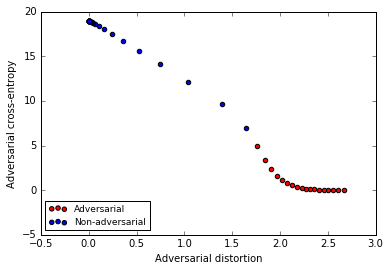

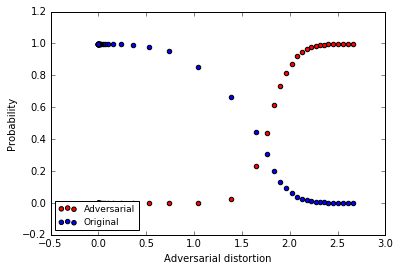

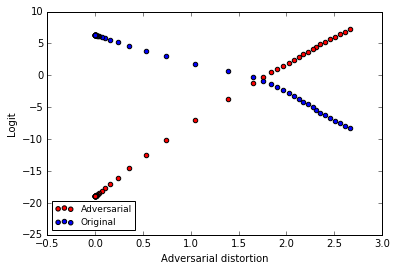

(3, 3, array([[  1.76884061e-12,   5.98571006e-08,   7.40755013e-09,
          9.99999881e-01,   1.86531389e-12,   5.05938180e-09,
          7.56055375e-12,   8.15836912e-11,   2.13898179e-08,
          5.00678166e-09]], dtype=float32))
Img 1383 Adv label 7


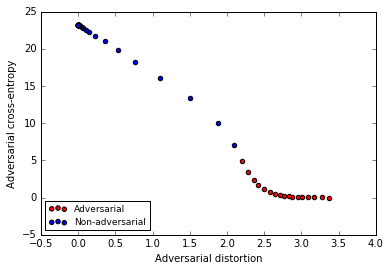

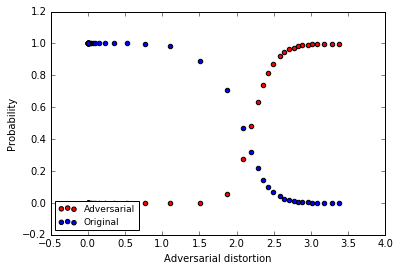

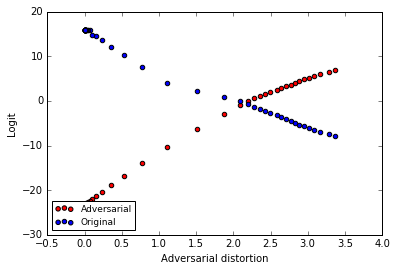

(9, 9, array([[  6.46377916e-13,   5.03187376e-15,   4.03439125e-15,
          2.93025854e-10,   4.41568698e-10,   2.00939647e-11,
          8.94072591e-17,   3.44581208e-09,   4.13519479e-12,
          1.00000000e+00]], dtype=float32))
Img 5333 Adv label 6


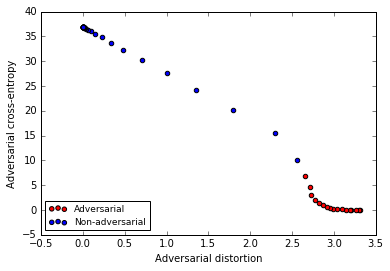

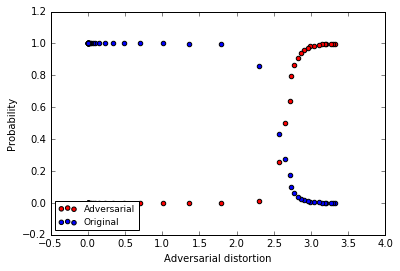

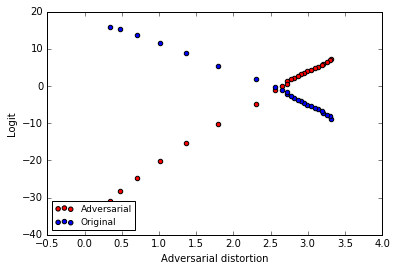

(9, 9, array([[  8.67848675e-12,   2.27406960e-12,   9.97470444e-13,
          6.82277901e-10,   5.01408022e-06,   2.28173702e-10,
          7.20756842e-13,   4.50374626e-09,   4.36491575e-07,
          9.99994516e-01]], dtype=float32))
Img 5001 Adv label 2


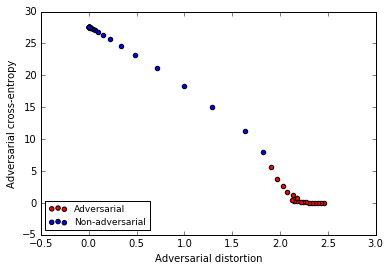

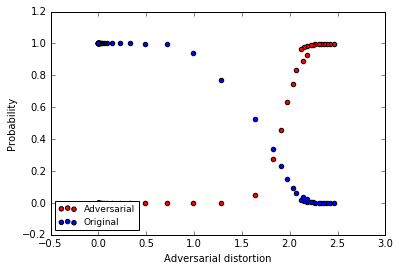

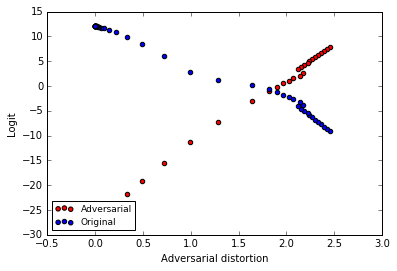

In [22]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

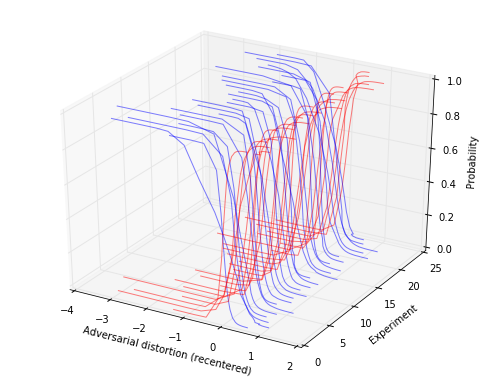

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

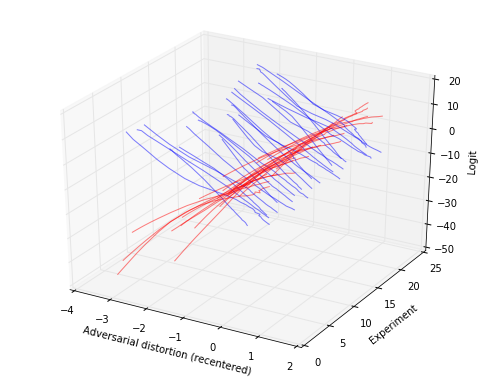

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Adversarial distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Logit')
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

(2, 2, array([[  2.17489516e-14,   3.56716653e-12,   1.00000000e+00,
          2.51087883e-11,   5.06990838e-11,   1.24926221e-14,
          1.58846146e-12,   5.00945788e-14,   6.99136230e-16,
          7.23589860e-16]], dtype=float32))
Img 3035 Adv label 1


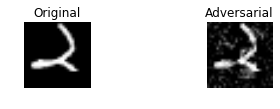

3.62523111127 0.00069002 0.998827


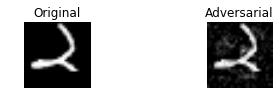

2.46742912179 0.519171 0.329716


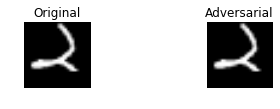

6.06380864916e-06 1.0 3.56739e-12


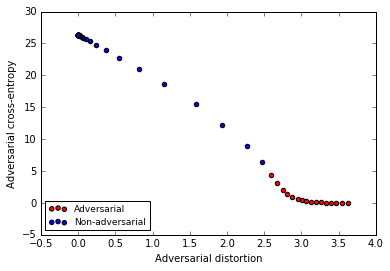

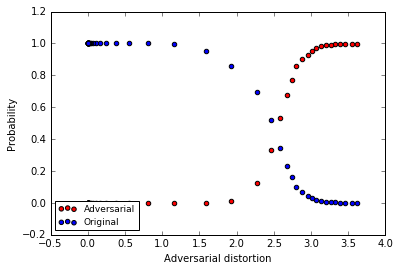

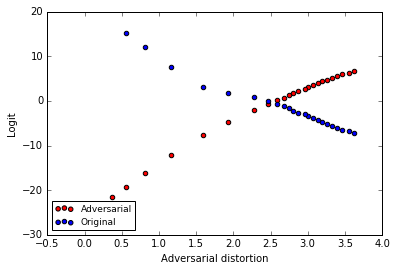

In [39]:
_, _, _, _ =orig_adv_dist(plot = True)

(1, 1, array([[  5.07585529e-10,   9.99981165e-01,   2.40451698e-07,
          3.41525599e-08,   3.14402513e-07,   2.34797763e-08,
          3.53402896e-07,   1.52336079e-05,   2.59304443e-06,
          6.51552057e-09]], dtype=float32))
Img 40 Adv label 4


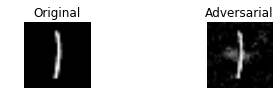

1.93107734779 0.000318038 0.999523


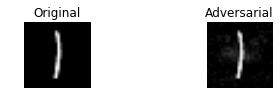

1.07150335705 0.542065 0.428552


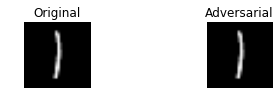

7.42242325343e-06 0.999981 3.14429e-07


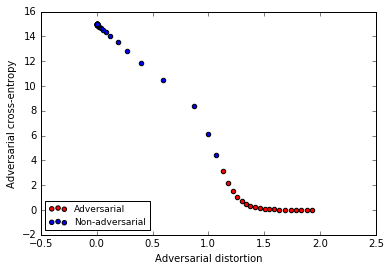

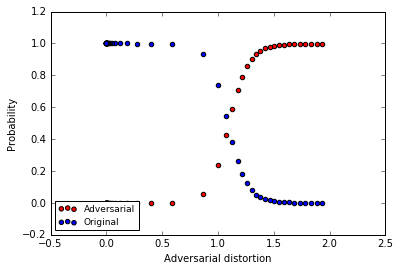

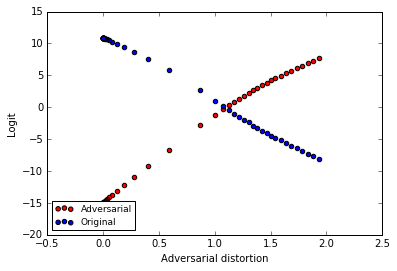

In [40]:
_, _, _, _ =orig_adv_dist(plot = True)